In [1]:
# import required packages
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
# fetch data
data = pd.read_excel('proc1a.xls', skiprows = 1,usecols = 'C:AI')

# separate train data
data_train = data.iloc[0:69,]
           
# scale data
scaler = StandardScaler()
data_train_normal = scaler.fit_transform(data_train)
           
# PCA
pca = PCA()
score_train = pca.fit_transform(data_train_normal)

# decide # of PCs to retain and compute reduced data in PC space
explained_variance = 100*pca.explained_variance_ratio_ # in percentage
cum_explained_variance = np.cumsum(explained_variance) # cumulative % variance explained

n_comp = np.argmax(cum_explained_variance >= 90) + 1
score_train_reduced = score_train[:,0:n_comp]

print('Number of PCs cumulatively explaining atleast 90% variance: ', n_comp)

Number of PCs cumulatively explaining atleast 90% variance:  13


In [3]:
# reconstruct original data
V_matrix = pca.components_.T
P_matrix = V_matrix[:,0:n_comp] 

data_train_normal_reconstruct = np.dot(score_train_reduced, P_matrix.T)

In [4]:
# calculate T2 for training data
lambda_k = np.diag(pca.explained_variance_[0:n_comp]) # eigenvalue = explained variance
lambda_k_inv = np.linalg.inv(lambda_k)

T2_train = np.zeros((data_train_normal.shape[0],))

for i in range(data_train_normal.shape[0]):
    T2_train[i] = np.dot(np.dot(score_train_reduced[i,:],lambda_k_inv),score_train_reduced[i,:].T)

# calculate Q for training data
error_train = data_train_normal - data_train_normal_reconstruct
Q_train = np.sum(error_train*error_train, axis = 1)

In [8]:
# T2_train control limit
import scipy.stats

N = data_train_normal.shape[0]
k = n_comp

alpha = 0.01# 99% control limit
T2_CL = k*(N**2-1)*scipy.stats.f.ppf(1-alpha,k,N-k)/(N*(N-k))

# Q_train control limit
eig_vals = pca.explained_variance_
print(eig_vals)
print(len(eig_vals))


m = data_train_normal.shape[1]



theta1 = np.sum(eig_vals[k:])
theta2 = np.sum([eig_vals[j]**2 for j in range(k,m)])
theta3 = np.sum([eig_vals[j]**3 for j in range(k,m)])
h0 = 1-2*theta1*theta3/(3*theta2**2)

z_alpha = scipy.stats.norm.ppf(1-alpha)
Q_CL = theta1*(z_alpha*np.sqrt(2*theta2*h0**2)/theta1+ 1 + theta2*h0*(1-h0)/theta1**2)**2 

[6.42279766e+00 5.52934815e+00 5.21780479e+00 2.57592955e+00
 1.94905677e+00 1.65466630e+00 1.42445525e+00 1.27523465e+00
 1.03022819e+00 1.00510271e+00 8.65028030e-01 8.39418790e-01
 6.66817847e-01 6.17976692e-01 5.67566781e-01 3.17816975e-01
 2.59451591e-01 2.35161769e-01 2.07151551e-01 1.71938116e-01
 1.59767319e-01 1.06331316e-01 8.74888021e-02 6.69980958e-02
 5.06341050e-02 4.42066867e-02 3.76185212e-02 3.17127595e-02
 2.31428729e-02 2.11885220e-02 1.48068960e-02 8.43406567e-03
 1.19984383e-05]
33


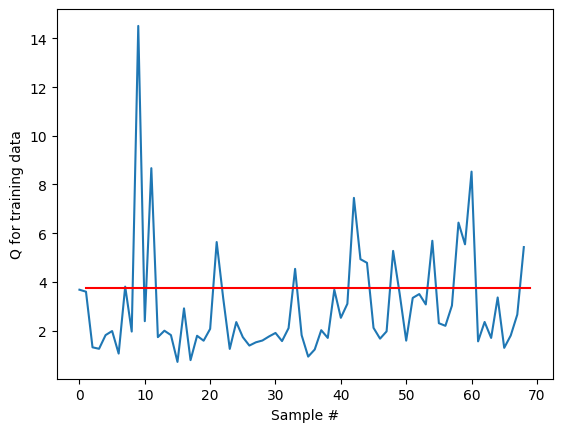

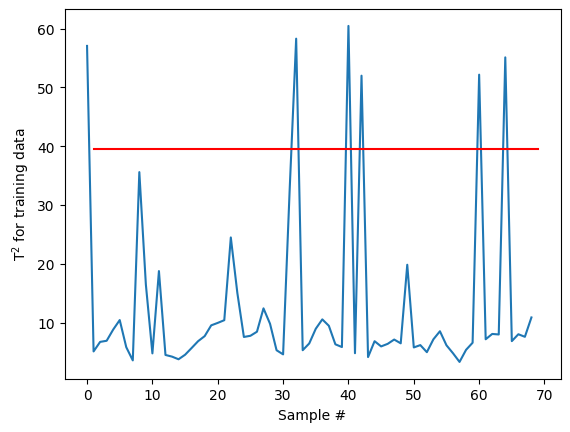

In [6]:
#%% Q_train plot with CL
plt.figure()
plt.plot(Q_train)
plt.plot([1,len(Q_train)],[Q_CL,Q_CL], color='red')
plt.xlabel('Sample #')
plt.ylabel('Q for training data')
plt.show()

#%% T2_train plot with CL
plt.figure()
plt.plot(T2_train)
plt.plot([1,len(T2_train)],[T2_CL,T2_CL], color='red')
plt.xlabel('Sample #')
plt.ylabel('T$^2$ for training data')
plt.show()